# Weakly Supervised Room Classification with YOLOv3 and Snorkel

This notebook is based on the idea that one of the difficulties in classifying hotels may be that we see very different rooms. We can't usually see both the bedroom and bathroom in the same photo, and some hotels have other spaces which are distinct from either (kitchens, etc). It's not particularly likely that the mapping between a particular bathroom and bedroom features is obvious.

The idea behind this notebook is to detect objects associated with particular rooms and views, such as toilets and sinks in the bathroom, and beds for the bedroom. We use Snorkel as a framework for handling and combining noisy labels.

In [1]:
!pip install -q snorkel pytorchyolo opencv-python torch==1.10.2 torchvision==0.11.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.
thinc 8.0.15 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.1.1 which is incompatible.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tfx-bsl 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import snorkel
from snorkel.labeling import labeling_function, LFAnalysis, PandasLFApplier
from snorkel.preprocess import preprocessor
from snorkel.labeling.model import LabelModel

Note that the YOLO directory below is in a private dataset. The repository I clone in that is GPLv3 licensed, so I can't republish under the Apache license.

You can find the script to download the data from https://github.com/eriklindernoren/PyTorch-YOLOv3 . The code is loaded through Pip, because it was painful to get dependencies to work otherwise.

In [4]:
YOLO_DIR = '/kaggle/input/pytorch-yolov3/PyTorch-YOLOv3/'
DATA_DIR = '/kaggle/input/hotel-id-to-combat-human-trafficking-2022-fgvc9/'
yolo_coco = '../input/yolo-coco-data'

Snorkel uses a series of integer class labels, starting at zero. The negative label signifies no decision.

In [5]:
# Class labels to apply
ABSTAIN = -1
BEDROOM = 0
BATHROOM = 1
OTHER = 2

We find all the training images, and collate them by Hotel ID (the directory name).

In [6]:
data = {"full_path": [], "image": [], "hotel_id": []}
for subdir in os.listdir(DATA_DIR + '/train_images/'):
    hotel_id = int(subdir)
    for image in os.listdir(f'{DATA_DIR}/train_images/{hotel_id}'):
        path = f'{DATA_DIR}/train_images/{hotel_id}/{image}'
        data['image'].append(image)
        data['full_path'].append(path)
        data['hotel_id'].append(hotel_id)

df = pd.DataFrame(data)
df.head()

,full_path,image,hotel_id
0,/kaggle/input/hotel-id-to-combat-human-traffic...,000011648.jpg,15526
1,/kaggle/input/hotel-id-to-combat-human-traffic...,000011630.jpg,15526
2,/kaggle/input/hotel-id-to-combat-human-traffic...,000011650.jpg,15526
3,/kaggle/input/hotel-id-to-combat-human-traffic...,000011633.jpg,15526
4,/kaggle/input/hotel-id-to-combat-human-traffic...,000011656.jpg,15526


The below line, if uncommented, reduces the amount of data used for testing.

In [7]:
#df = df.sample(1000, random_state=42)

We use YOLOv3 to construct a Snorkel "preprocessor". This will process each sample, and extract computer-readable information. In this case, it's the objects detected by YOLO.

In [8]:
from pytorchyolo import models, detect
yolo_model = models.load_model(yolo_coco + '/yolov3.cfg', yolo_coco + '/yolov3.weights')

labels = []
with open(yolo_coco + '/coco.names', 'r') as f:
    for line in f:
        labels.append(line.strip())
@preprocessor(memoize=True)
def object_detection(x):
    # Load the image as a numpy array
    img = cv2.imread(x.full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Runs the YOLO model on the image 
    boxes = detect.detect_image(yolo_model, img)
    
    # Re-map the integer class label in to a string
    objects = []
    for x1, y1, x2, y2, confidence, c in boxes:
        label = labels[int(c)]
        objects.append((x1, y1, x2, y2, confidence, label))
    x.object_boxes = objects
    return x

Each of the following is a "labeling function" for Snorkel. They are expected to be heuristic, somewhat noisy classifiers, which are allowed to return "don't know" or abstain. Each looks for one or more features with reasonable confidence, and will declare it to be a particular type of room if found. Snorkel will later combine these noisy labels together.

In [9]:
@labeling_function(pre=[object_detection])
def toilet_in_bathroom(x):
    for x1, y1, x2, y2, confidence, label in x.object_boxes:
        if label == 'toilet' and confidence > 0.5:
            return BATHROOM
    return ABSTAIN

@labeling_function(pre=[object_detection])
def sink_in_bathroom(x):
    for x1, y1, x2, y2, confidence, label in x.object_boxes:
        if label == 'sink' and confidence > 0.5:
            return BATHROOM
    return ABSTAIN

@labeling_function(pre=[object_detection])
def bed_in_bedroom(x):
    for x1, y1, x2, y2, confidence, label in x.object_boxes:
        if label == 'bed' and confidence > 0.5:
            return BEDROOM
    return ABSTAIN

@labeling_function(pre=[object_detection])
def oven_in_kitchen(x):
    for x1, y1, x2, y2, confidence, label in x.object_boxes:
        if label == 'oven' and confidence > 0.5:
            return OTHER
    return ABSTAIN

@labeling_function(pre=[object_detection])
def microwave_in_kitchen(x):
    for x1, y1, x2, y2, confidence, label in x.object_boxes:
        if label == 'microwave' and confidence > 0.5:
            return OTHER
    return ABSTAIN

@labeling_function(pre=[object_detection])
def fridge_in_kitchen(x):
    for x1, y1, x2, y2, confidence, label in x.object_boxes:
        if label == 'refrigerator' and confidence > 0.5:
            return OTHER
    return ABSTAIN

@labeling_function(pre=[object_detection])
def default_other(x):
    reliable_classifiers = [toilet_in_bathroom, sink_in_bathroom, bed_in_bedroom]
    if all([c(x) == ABSTAIN for c in reliable_classifiers]):
        return OTHER
    return ABSTAIN

We apply our label functions to our data, to extract the prediction that each function produced for each output as a 2D array.

In [10]:
lfs = [toilet_in_bathroom, sink_in_bathroom, bed_in_bedroom, oven_in_kitchen, microwave_in_kitchen, fridge_in_kitchen, default_other]

applier = PandasLFApplier(lfs=lfs)
L = applier.apply(df=df)
L

100%|██████████| 44703/44703 [2:39:23<00:00,  4.67it/s]


array([[-1, -1, -1, ..., -1, -1,  2],
       [-1, -1,  0, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1,  2],
       ...,
       [-1, -1,  0, ..., -1, -1, -1],
       [-1, -1,  0, ..., -1, -1, -1],
       [-1, -1,  0, ..., -1, -1, -1]])

We can view coverage, overlap, and conflict statistics for each function, showing how valuable they are for labelling, or whether they're redundant.

In [11]:
LFAnalysis(L=L, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
toilet_in_bathroom,0,[1],0.153144,0.074939,0.001678
sink_in_bathroom,1,[1],0.126636,0.079726,0.006465
bed_in_bedroom,2,[0],0.526721,0.008590,0.008590
oven_in_kitchen,3,[2],0.001790,0.001790,0.001074
microwave_in_kitchen,4,[2],0.009507,0.009507,0.004698
fridge_in_kitchen,5,[2],0.006868,0.006868,0.003221
default_other,6,[2],0.272040,0.007404,0.000000


We show a sample of what each rule is picking up and labelling, to see whether these are reasonable. It's interesting to note that some of the "confused" images we see (e.g. the bed it thinks is a fridge) are rotated wrong - correcting that may be a path to improvement.

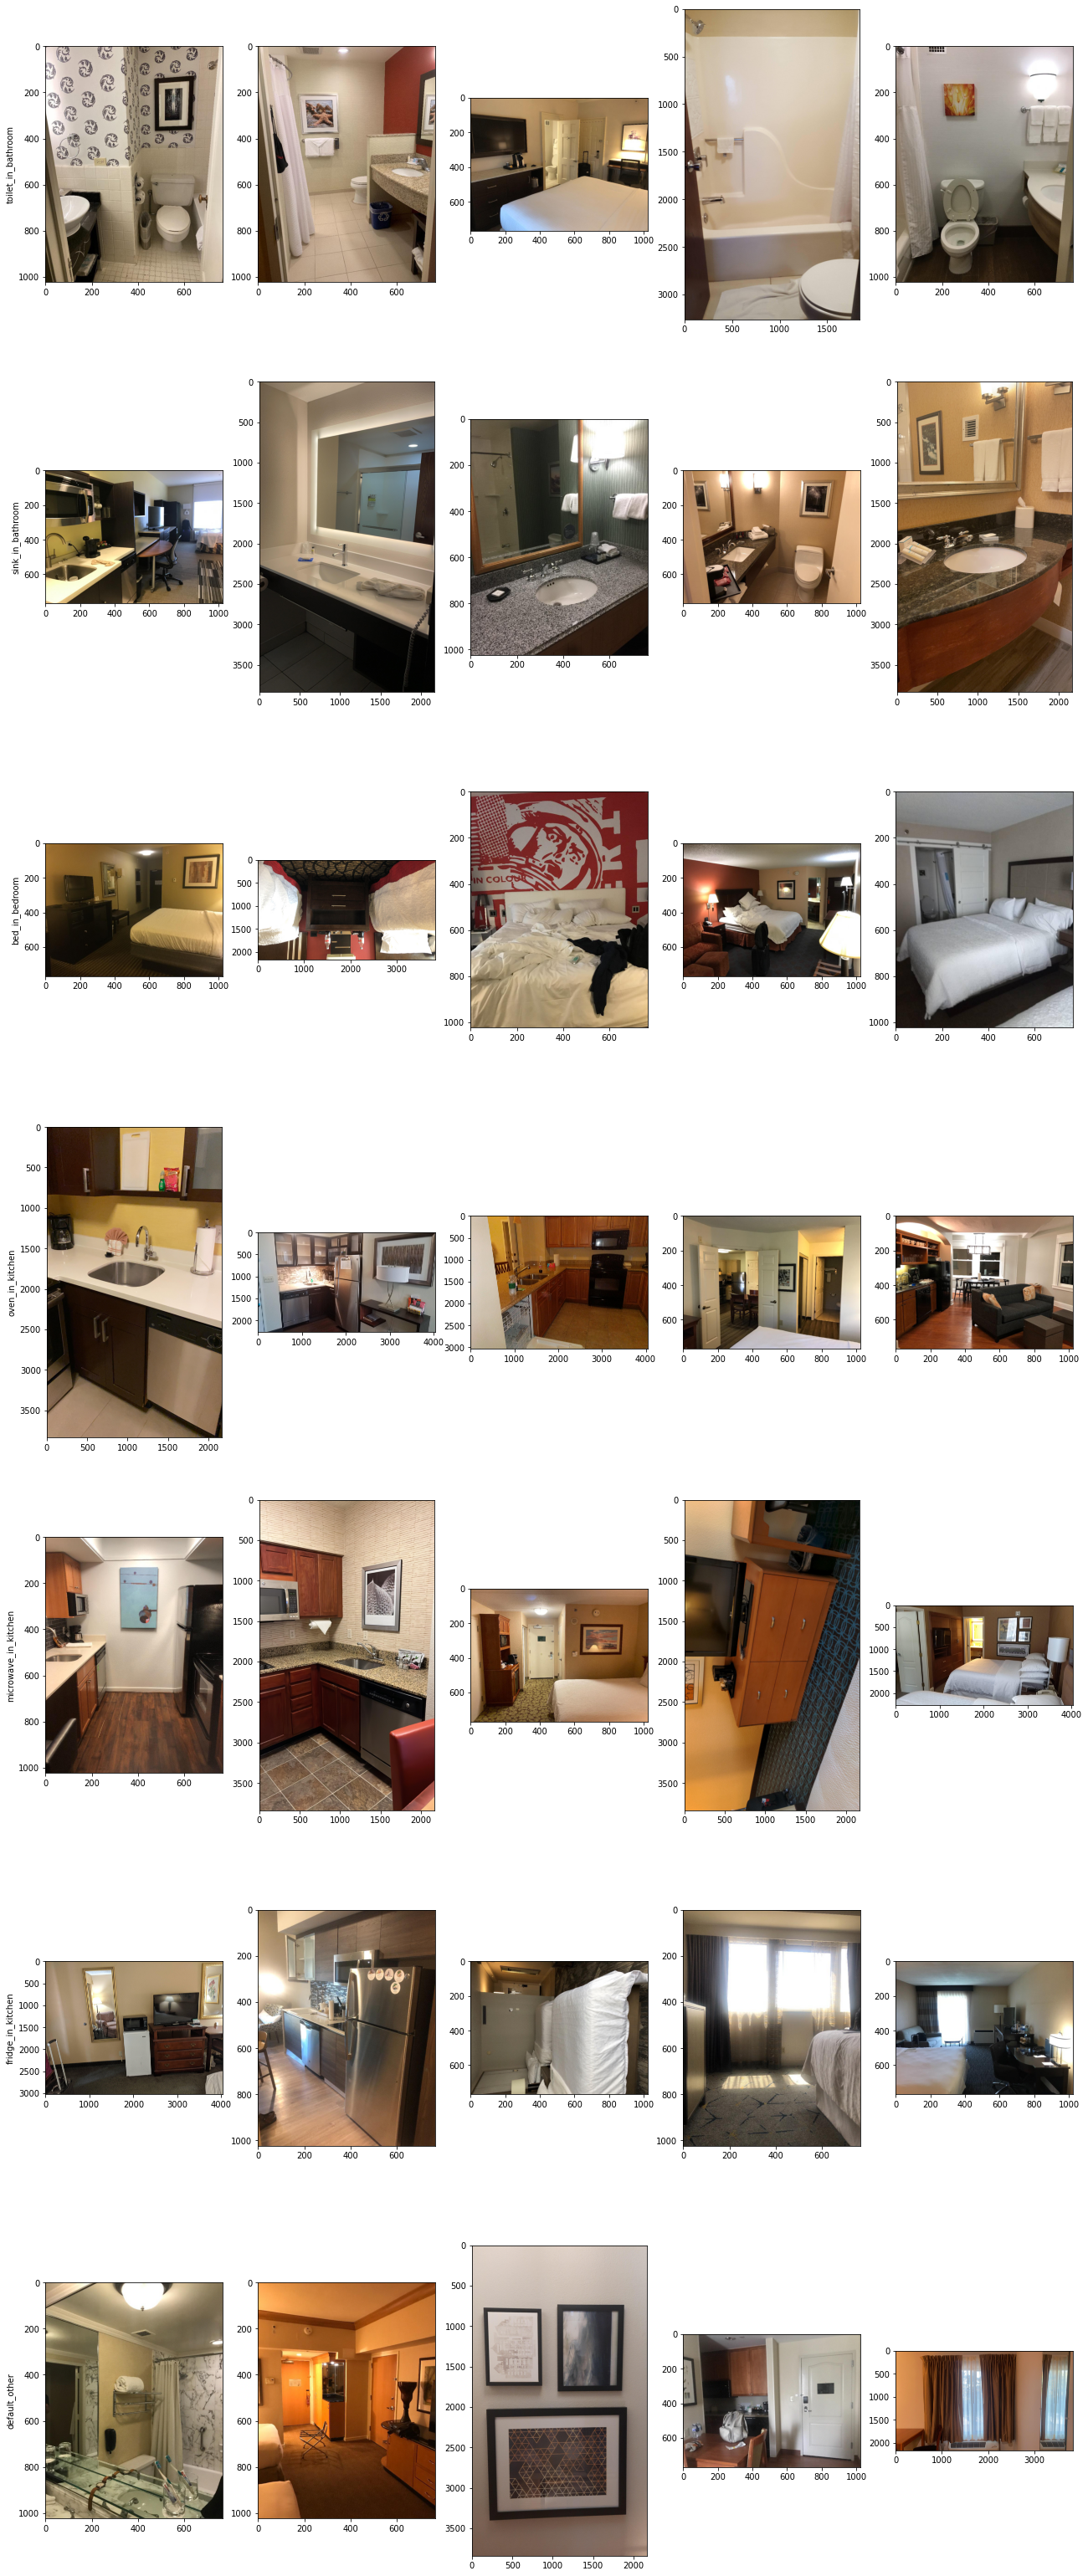

In [12]:
NUM_IMAGES = 5

fig, ax = plt.subplots(len(lfs), NUM_IMAGES, figsize=(22,8 * len(lfs)))
for i, lf in enumerate(lfs):
    ax[i][0].set_ylabel(lf.name)
    
    matched = df.iloc[np.not_equal(L[:, i], ABSTAIN)]
    sample = matched.sample(min(len(matched), NUM_IMAGES), random_state=1000+i)
    for j, path in enumerate(sample['full_path']):
        ax[i][j].imshow(mpimg.imread(path))

Snorkel can train a model based on the provided labels. My understanding of this step is limited, but I believe it will end up evaluating functions by their conflicts, weighting the most reliably agreeing ones higher.

In [13]:
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train=L, n_epochs=500, log_freq=100, seed=123)

100%|██████████| 500/500 [00:00<00:00, 1125.33epoch/s]


We can now produce our noisy labels. Note that this is always a best-effort process, and so a confidence measure is produced alongside the peak prediction.

In [14]:
P, C = label_model.predict(L, return_probs=True)
LABELS = ['unknown', 'bedroom', 'bathroom', 'other']

ldf = df.copy()[['hotel_id', 'image']]
ldf['room_type'] = [LABELS[p+1] for p in P]
for i, l in enumerate(LABELS[1:]):
    ldf['p_' + l] = C[:, i]
ldf.head()

,hotel_id,image,room_type,p_bedroom,p_bathroom,p_other
0,15526,000011648.jpg,other,1.112770e-05,0.035367,9.646219e-01
1,15526,000011630.jpg,bedroom,7.767367e-01,0.125959,9.730464e-02
2,15526,000011650.jpg,other,1.112770e-05,0.035367,9.646219e-01
3,15526,000011633.jpg,bathroom,4.411601e-10,1.000000,4.411601e-10
4,15526,000011656.jpg,bathroom,1.872650e-05,0.999963,1.872650e-05


Summarise how many rooms ended up labeled as each type:

In [15]:
for l in LABELS:
    c = len(ldf[ldf['room_type'] == l])
    print(f'{l}: {c}')

unknown: 0
bedroom: 23298
bathroom: 9226
other: 12179


And save the results.

In [16]:
ldf.to_csv('room-types.csv')

Snorkel models produce a "noisy" label set, don't generalise, and are rarely used directly. The normal path from here would be to train a classifier using the noisy labels, which gains the ability to generalise to other examples. A trained classifier is also likely to fill in the "unknown" elements, and provided it's not overfitted too much, may have a smoothing effect that lets it express reduced confidence in anything we labelled wrongly with these heuristics.

For this competition, these heuristics may well be "good enough" to use directly for some purposes.